
## CNN for Predictive Maintenance

This notebook walks you through **Convolutional Neural Networks (CNNs)** for **predictive maintenance** using PyTorch.

**You will learn:**
- Convolution
- Convolution Layer
- Feature Map
- Introducing Non-Linearity (ReLU)
- Pooling / Downsampling
- Fully Connected Layer (FCL)
- Putting it all together on a real dataset

**Dataset**
```python
url = "https://raw.githubusercontent.com/Dr-AlaaKhamis/ISE518/refs/heads/main/datasets/predictive_maintenance.csv"
```


### 1️⃣ Setup

In [ ]:
# Core
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

# Utils
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

### 2️⃣ Load and preview the dataset

In [2]:
url = "https://raw.githubusercontent.com/Dr-AlaaKhamis/ISE518/refs/heads/main/datasets/predictive_maintenance.csv"
df = pd.read_csv(url)
print("Shape:", df.shape)
df.head()

Shape: (10000, 10)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure



### 3️⃣ Preprocessing

- Drop non-feature ID columns
- Encode the target label
- Scale features
- Shape tensors for **1D-CNN** as `(batch, channels=1, width=number_of_features)`


In [4]:
# Drop non-numeric identifiers if present
df = df.drop(columns=['UDI', 'Product ID'], errors='ignore')

# Identify target column
target_col = 'Target' if 'Target' in df.columns else df.columns[-1]

# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['number']).columns

print("Categorical columns:", list(cat_cols))
print("Numeric columns:", list(num_cols))

# Encode categorical columns (if any)
if len(cat_cols) > 0:
    X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)
else:
    X_encoded = X.copy()

# Encode target if needed
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.astype(str))

# Scale numeric data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Convert to tensors
import torch
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

Categorical columns: ['Type', 'Failure Type']
Numeric columns: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']


### 4️⃣ Convolution & Feature Maps

**Convolution** slides a small filter (kernel) over the input to detect local patterns.  
The output is a **feature map** showing where those patterns appear.

Below, we define a simple **1D CNN** for tabular features treated as a 1D signal.


In [6]:
class CNNMaintenance(nn.Module):
    def __init__(self, input_width: int, num_classes: int):
        super().__init__()
        # --- Convolution layers ---
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3)  # -> (W-2)
        self.pool = nn.MaxPool1d(kernel_size=2)                                 # -> floor((W-2)/2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3)  # -> floor((W-2)/2) - 2

        # Compute flattened size dynamically using a dummy pass
        with torch.no_grad():
            x = torch.zeros(1, 1, input_width)
            x = self.pool(F.relu(self.conv1(x)))
            x = F.relu(self.conv2(x))
            flat_feats = x.view(1, -1).shape[1]

        # --- Fully Connected head ---
        self.fc1 = nn.Linear(flat_feats, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Convolution -> Nonlinearity -> Pooling
        x = self.conv1(x)        # Convolution Layer
        x = F.relu(x)            # Introducing Non-Linearity
        x = self.pool(x)         # Pooling / Downsampling

        # Second conv block
        x = self.conv2(x)
        x = F.relu(x)

        # Flatten -> FCL
        x = torch.flatten(x, 1)
        x = self.fc1(x)          # Fully Connected Layer (FCL)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [7]:
# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

# Define input width for CNN
input_width = X_tensor.shape[2]
num_classes = len(np.unique(y_encoded))

# Split dataset
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32)

# Create model
model = CNNMaintenance(input_width=input_width, num_classes=num_classes)
print(model)

CNNMaintenance(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=96, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


In [8]:
from torchsummary import summary

# Show CNN layer-by-layer summary
summary(model, input_size=(1, input_width))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 16, 10]              64
         MaxPool1d-2                [-1, 16, 5]               0
            Conv1d-3                [-1, 32, 3]           1,568
            Linear-4                   [-1, 64]           6,208
            Linear-5                    [-1, 2]             130
Total params: 7,970
Trainable params: 7,970
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


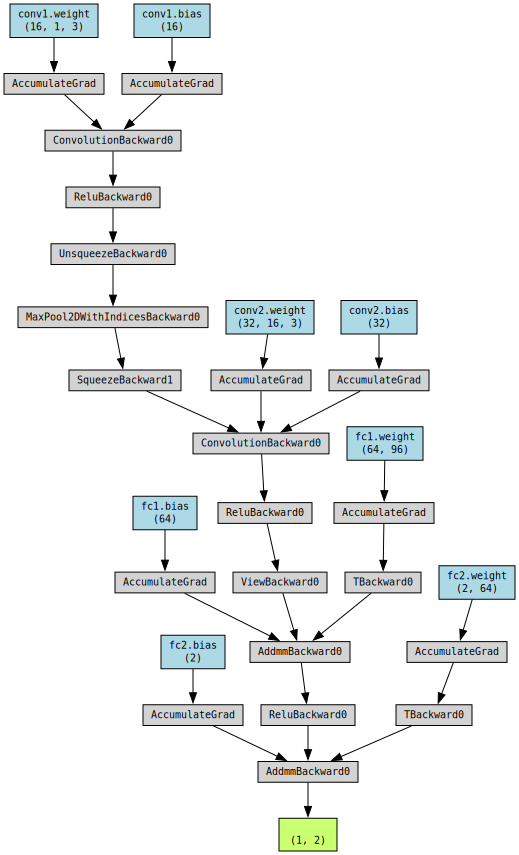

In [10]:
# Visualize computational graph (optional)
from torchviz import make_dot
dummy_input = torch.randn(1, 1, input_width)
y = model(dummy_input)
make_dot(y, params=dict(model.named_parameters()))

### 5️⃣ Train the CNN

We optimize **cross-entropy loss** with **Adam**. The printed loss shows progress.


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 15
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for xb, yb in train_dl:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg = total_loss / len(train_dl)
    train_losses.append(avg)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg:.4f}")

Epoch 1/15 - Loss: 0.0668
Epoch 2/15 - Loss: 0.0086
Epoch 3/15 - Loss: 0.0085
Epoch 4/15 - Loss: 0.0086
Epoch 5/15 - Loss: 0.0082
Epoch 6/15 - Loss: 0.0085
Epoch 7/15 - Loss: 0.0084
Epoch 8/15 - Loss: 0.0081
Epoch 9/15 - Loss: 0.0082
Epoch 10/15 - Loss: 0.0076
Epoch 11/15 - Loss: 0.0079
Epoch 12/15 - Loss: 0.0075
Epoch 13/15 - Loss: 0.0070
Epoch 14/15 - Loss: 0.0075
Epoch 15/15 - Loss: 0.0072


### Training loss curve

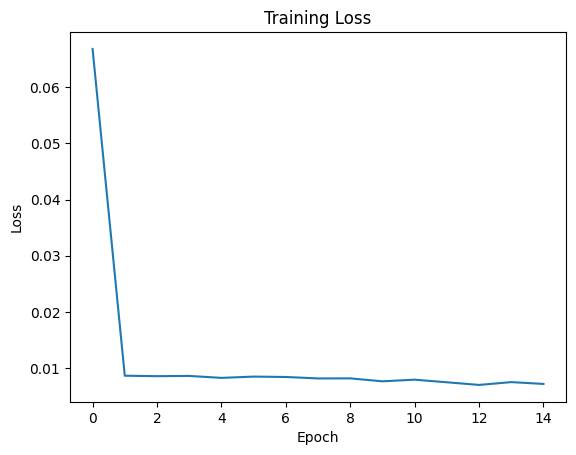

In [12]:
plt.figure()
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

### 6️⃣ Evaluate

In [13]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        logits = model(xb)
        preds = logits.argmax(dim=1)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Classes:", list(le.classes_))
print()
print(classification_report(y_true, y_pred, target_names=le.classes_))

Classes: ['0', '1']

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1929
           1       1.00      0.99      0.99        71

    accuracy                           1.00      2000
   macro avg       1.00      0.99      1.00      2000
weighted avg       1.00      1.00      1.00      2000



### 7️⃣ Single-sample Inference

In [15]:
model.eval()
with torch.no_grad():
    logits = model(sample)
    pred = logits.argmax(dim=1).item()
print("True label:", le.classes_[yb[0].item()])
print("Predicted  :", le.classes_[pred])

True label: 0
Predicted  : 0


### 8️⃣  Tips to Improve

- Try **more filters** or **deeper networks** (e.g., add `conv3`).
- Use **dropout** or **weight decay** to regularize.
- Tune **learning rate** and **epochs**.
- Handle **class imbalance** (e.g., class weights or resampling).
- Consider **1D-CNN on raw time-series** per sensor instead of tabular features, if available.
